# Imports
___

In [38]:
import warnings

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame
___

In [39]:
posts = pd.read_csv('Datasets/reddit_posts_scrape.csv')

In [40]:
posts.head()

,title,selftext,subreddit,created_utc
0,Can a nuclear bomb set off another nuke?,[removed],askscience,1646168184
1,"God forbid, Russia decides to go for the n nuc...",[removed],askscience,1646168000
2,Why can the common cold coexist with Covid?,[removed],askscience,1646167864
3,What fuel burns for the longest?,[removed],askscience,1646167761
4,Electromagnetic force,[removed],askscience,1646167434


In [41]:
posts.shape

(2095, 4)

In [42]:
posts['subreddit'].unique()

array(['askscience', 'unpopularopinion'], dtype=object)

In [43]:
posts['target'] = posts['subreddit'].map({'askscience':0, 'unpopularopinion': 1})

In [44]:
posts.head()

,title,selftext,subreddit,created_utc,target
0,Can a nuclear bomb set off another nuke?,[removed],askscience,1646168184,0
1,"God forbid, Russia decides to go for the n nuc...",[removed],askscience,1646168000,0
2,Why can the common cold coexist with Covid?,[removed],askscience,1646167864,0
3,What fuel burns for the longest?,[removed],askscience,1646167761,0
4,Electromagnetic force,[removed],askscience,1646167434,0


# Cleaning
___

In [45]:
posts.isna().sum()

title           0
selftext       11
subreddit       0
created_utc     0
target          0
dtype: int64

In [46]:
posts.fillna('', inplace=True)

In [47]:
posts['selftext'] = posts['selftext'].map(lambda x: '' if x =='[removed]' else x)

In [48]:
posts.isna().sum()

title          0
selftext       0
subreddit      0
created_utc    0
target         0
dtype: int64

In [49]:
posts['all_text'] = (posts["title"] + posts["selftext"])

In [50]:
posts.head()

,title,selftext,subreddit,created_utc,target,all_text
0,Can a nuclear bomb set off another nuke?,,askscience,1646168184,0,Can a nuclear bomb set off another nuke?
1,"God forbid, Russia decides to go for the n nuc...",,askscience,1646168000,0,"God forbid, Russia decides to go for the n nuc..."
2,Why can the common cold coexist with Covid?,,askscience,1646167864,0,Why can the common cold coexist with Covid?
3,What fuel burns for the longest?,,askscience,1646167761,0,What fuel burns for the longest?
4,Electromagnetic force,,askscience,1646167434,0,Electromagnetic force


## Adding feature columns
___

#### Adding word count

In [51]:
posts['word_count'] = posts['all_text'].map(lambda x: len([x for words in x.split()]))

#### The data is filtered and ready for addding the sentiment column

In [52]:
sia = SentimentIntensityAnalyzer()

In [53]:
def extract_sentiment(post):
    scores = sia.polarity_scores(post)
    return scores['compound']

In [54]:
posts['sentiment'] = (posts['all_text']).map(extract_sentiment)

In [55]:
posts.head()

,title,selftext,subreddit,created_utc,target,all_text,word_count,sentiment
0,Can a nuclear bomb set off another nuke?,,askscience,1646168184,0,Can a nuclear bomb set off another nuke?,8,-0.4939
1,"God forbid, Russia decides to go for the n nuc...",,askscience,1646168000,0,"God forbid, Russia decides to go for the n nuc...",15,-0.0516
2,Why can the common cold coexist with Covid?,,askscience,1646167864,0,Why can the common cold coexist with Covid?,8,0.0000
3,What fuel burns for the longest?,,askscience,1646167761,0,What fuel burns for the longest?,6,0.0000
4,Electromagnetic force,,askscience,1646167434,0,Electromagnetic force,2,0.0000


#### Export Cleaned Dataset for Modeling:

In [56]:
posts.to_csv('Datasets/reddit_posts_clean.csv', index=False)

## Analysis and insights
___

### Sentiment

In [57]:
posts.groupby('subreddit').mean()['sentiment']

subreddit
askscience          0.011497
unpopularopinion   -0.031249
Name: sentiment, dtype: float64

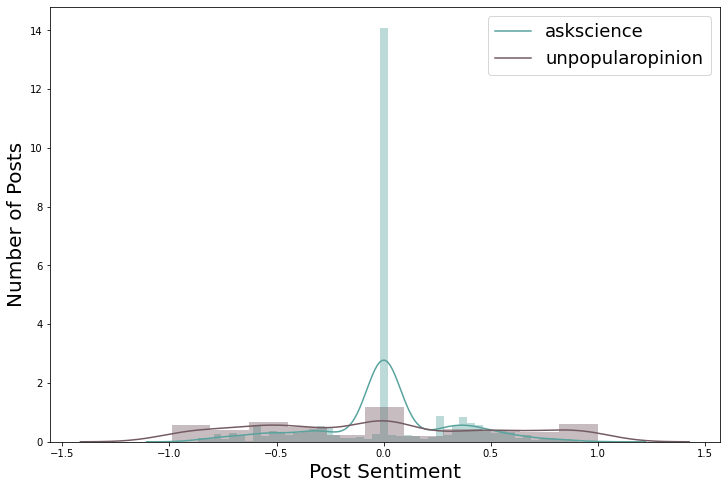

In [59]:
with warnings.catch_warnings(record=True):
# remove depricated function warning

    plt.figure(figsize=(12, 8))
    sns.distplot(x = posts[posts['subreddit']=='askscience'] ['sentiment'], color='#58a39e'),
    sns.distplot(x= posts[posts['subreddit']=='unpopularopinion'] ['sentiment'], color='#745b62')
    plt.legend(labels=['askscience','unpopularopinion'], fontsize = 18)
    plt.xlabel("Post Sentiment", fontsize = 20)
    plt.ylabel("Number of Posts", fontsize = 20);

___This displays the distribution of sentiment by subreddit. Based on this, it seems that discussions in askscience are more neutral in tone, while posts to unpopular opinion seem to be very polarized.___

### Word Count

In [60]:
posts.groupby('subreddit').mean()['word_count']

subreddit
askscience          13.543544
unpopularopinion    48.190693
Name: word_count, dtype: float64

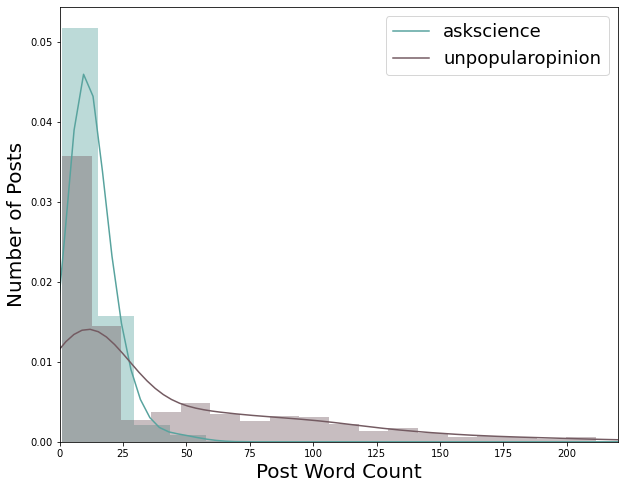

In [61]:
with warnings.catch_warnings(record=True):
# remove depricated function warning

    plt.figure(figsize=(10, 8))
    plt.xlim(0, 220)
    sns.distplot(x = posts[posts['subreddit']=='askscience'] ['word_count'], color='#58a39e'),
    sns.distplot(x= posts[posts['subreddit']=='unpopularopinion'] ['word_count'], color='#745b62')
    plt.legend(labels=['askscience','unpopularopinion'], fontsize = 18)
    plt.xlabel("Post Word Count", fontsize = 20)
    plt.ylabel("Number of Posts", fontsize = 20);

___It seems that posts to askscience are generally shorter, having word counts that stay bellow 30 and average only 13.5. While many posts from askscience are on the shorter side, the right squewed distribution clearly demonstrates that many posts go well above this, and the average is nearly 50 words.___

### Show the 15 frequency of the most common words
___

In [62]:
asksci_posts = posts[posts['subreddit']== 'askscience']

In [63]:
unpop_posts = posts[posts['subreddit']== 'unpopularopinion']

#### Create top words pipeline

In [64]:
def get_title(df):
    return df['all_text']

get_title_trasnformer = FunctionTransformer(get_title, validate=False)

In [65]:
def sparse_to_dense(sparse_matrix):
    return np.asarray(sparse_matrix.todense())

sparse_to_dense_trasnformer = FunctionTransformer(sparse_to_dense, validate=False)

In [66]:
pipe = Pipeline([
    ('title_transform', get_title_trasnformer),
    ('cvec', CountVectorizer(stop_words='english')),
    ('sparse_to_dense_trasnformer', sparse_to_dense_trasnformer)
])

In [67]:
cvec_sci = CountVectorizer(stop_words='english')
cvec_sci.fit(asksci_posts['all_text'])

CountVectorizer(stop_words='english')

In [68]:
asksci_posts_cvec = pd.DataFrame(pipe.fit_transform(asksci_posts), columns=cvec_sci.get_feature_names_out())

In [69]:
asksci_words = asksci_posts_cvec.sum().sort_values(ascending=False)[:15]

In [70]:
cvec_unpop = CountVectorizer(stop_words='english')
cvec_unpop.fit(unpop_posts['all_text'])

CountVectorizer(stop_words='english')

In [71]:
unpop_posts_cvec = pd.DataFrame(pipe.fit_transform(unpop_posts), columns=cvec_unpop.get_feature_names_out())

In [72]:
unpop_words = unpop_posts_cvec.sum().sort_values(ascending=False)[:15]

#### Most Common Words in Each Subreddit:

In [73]:
asksci_words

does         105
possible      47
earth         43
like          40
nuclear       39
water         34
time          28
different     28
way           28
question      27
energy        26
work          25
long          24
body          24
covid         23
dtype: int64

In [74]:
unpop_words

people    444
like      333
just      314
don       231
think     172
time      131
better    125
good      121
make      103
need      101
want       98
really     91
life       90
know       90
way        85
dtype: int64